<a href="https://colab.research.google.com/github/DarwinFer/ExampleEDO/blob/main/E1OsciladorArminioPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejemplo 1:  Agragar la física al modelo

En adelante presentamos un ejemplo  que ilustra la diferencia de el uso de la física en la solición o aproximación de EDO's.


> Supongamos que estamos intentando modelar el  **oscilador armónico amortiguado**

<img src="https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif?raw=1" width="500">

(*Animación tomada  de https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif*)



Es decir, nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo $t$.

Este es un problema estandar en física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede describirse mediante la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~ \qquad (1)
$$


donde $m$ es la masa del oscilador, $\mu$ es el coeficiente de fricción y $k$ es la constante del resorte.

Nos enfocaremos en resolver el problema en el **estado subamortiguado**, es decir, cuando la oscilación se amortigua lentamente debido a la fricción (como se muestra en la animación de arriba).

Desde el punto de vista matemático, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.   \qquad (2)
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y está dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

Para una descripción matemática más detallada del oscilador armónico, consulta esta publicación en el blog: https://beltoforion.de/en/harmonic_oscillator/

##Generando datos de entrenamiento

>   Datos para la simulación:

Dado que este es un problema  con solución exacta conocida,  podemos generar datos de entremaniento  para que nuestra una red neuornal aprendrenda, primero definimos la solución exacta y la evaluamos en ciertos $t_{
i} \in [0,T_{train}]$. Como resultado tendremos datos etiquetados de la forma ${t_{i}, u(x_{i})}$, por su puesto para  los parametros convenientes del caso subamortiguado. Primero como es habitual empezamos importando las librerias,  en  este caso usaremos PyTorch como libreria base para la implementación de las redes neuronales.




In [14]:
#Importamos las librerias necesarias.
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

>En seguida, definimos una función que guarde la solución exacta de nuestro problema.

In [15]:
# ---- Solución exacta del oscilador armónico subamortiguado ----
def exact_solution(d, w0, t):
    """Solución analítica al problema del oscilador armónico subamortiguado"""
    # Parámetros a tensores PyTorch
    d_t = torch.tensor(d, dtype=torch.float32)
    w0_t = torch.tensor(w0, dtype=torch.float32)
    # Frecuencia amortiguada y fase inicial
    w = torch.sqrt(w0_t**2 - d_t**2)
    phi = torch.atan(-d_t / w)
    A = 1 / (2 * torch.cos(phi))
    # Solución exacta
    cos_term = torch.cos(phi + w * t)
    exp_term = torch.exp(-d_t * t)
    return exp_term * 2 * A * cos_term



In [16]:

# ---- Parámetros del sistema ----
d = 2.0        # coeficiente de fricción
w0 = 20.0      # frecuencia natural (> d para estado subamortiguado)

# ---- Definir dominios de tiempo ----n# Dominio para PLOT completo
t_plot_max = 1.0
# Dominio para DATOS de entrenamiento (hasta t < t_plot_max)
t_train_max = 0.4    # solo hasta t = T_{med}
num_points = 10      # número de puntos de entrenamiento

# Puntos de entrenamiento (hasta t_train_max)
t_train = torch.linspace(0, t_train_max, num_points).reshape(-1,1)
u_train = exact_solution(d, w0, t_train)


##Creando una red neuoronal  (NN)

>Siguiendo nuesto objetivo, creamos una red neuronal que aproxime la solución de  (2), mediante un rede neuronal la cual se entrena con los datos de entrenamiento previamente obtenidos. Aprovechando la capacidad de las redes neuronales como aproximadores universales  para aproximar directamente la solución de la ecuación diferencial, es decir,

$$
u_{\mathrm{NN}}(t;\theta) \approx u(t)~,
$$
>Supongamos que deseamos usar el error cuadratico medio para entregar nuestra red neuronal usando unicamente nuestros datos de entrenamiento previamente ilustrados

Epoch 500/10001, Loss: 0.000371
Epoch 1000/10001, Loss: 0.000022
Epoch 1500/10001, Loss: 0.000016
Epoch 2000/10001, Loss: 0.000003
Epoch 2500/10001, Loss: 0.000001
Epoch 3000/10001, Loss: 0.000000
Epoch 3500/10001, Loss: 0.000748
Epoch 4000/10001, Loss: 0.000000
Epoch 4500/10001, Loss: 0.000000
Epoch 5000/10001, Loss: 0.000005
Epoch 5500/10001, Loss: 0.000000
Epoch 6000/10001, Loss: 0.000000
Epoch 6500/10001, Loss: 0.000000
Epoch 7000/10001, Loss: 0.000044
Epoch 7500/10001, Loss: 0.000029
Epoch 8000/10001, Loss: 0.000000
Epoch 8500/10001, Loss: 0.000000
Epoch 9000/10001, Loss: 0.000040
Epoch 9500/10001, Loss: 0.000126
Epoch 10000/10001, Loss: 0.000002


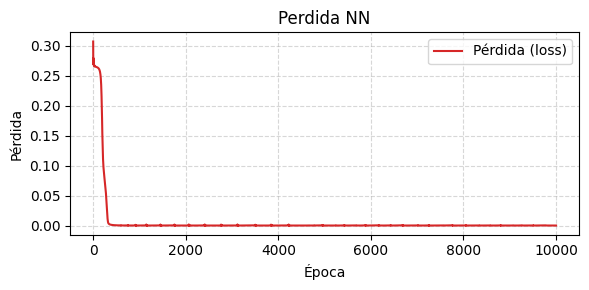

In [17]:

# ---- Modelo de red neuronal ----
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,1)
        )
    def forward(self, x):
        return self.net(x)

# Semilla y creación de modelo
torch.manual_seed(123)
model = SimpleNN()

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Marcar para autograd
t_train.requires_grad_(True)

# ---- Entrenamiento ----
epochs = 10001
loss_history = []
for ep in range(1, epochs+1):
    pred = model(t_train)
    loss = criterion(pred, u_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if ep % 500 == 0:
        print(f"Epoch {ep}/{epochs}, Loss: {loss.item():.6f}")
#plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(loss_history, label='Pérdida (loss)', color='tab:red')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Perdida NN')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Curva_PerdidaNN.pdf", format="pdf")
plt.show()

**Visualizar los resultados**:

Epoch 1000 - t = 1.000 - Error puntual L2 = 0.848661


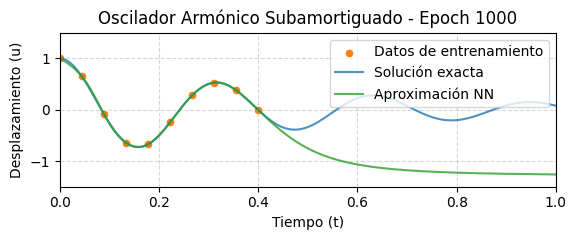

Epoch 2000 - t = 1.000 - Error puntual L2 = 0.847268


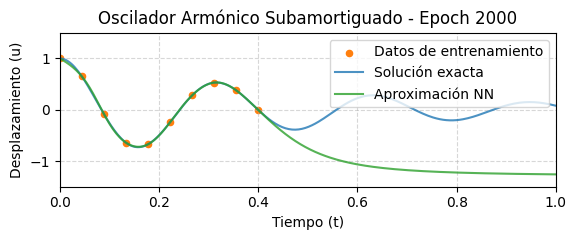

Epoch 3000 - t = 1.000 - Error puntual L2 = 0.848379


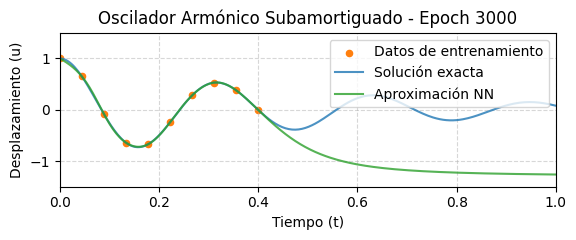

Epoch 4000 - t = 1.000 - Error puntual L2 = 0.848043


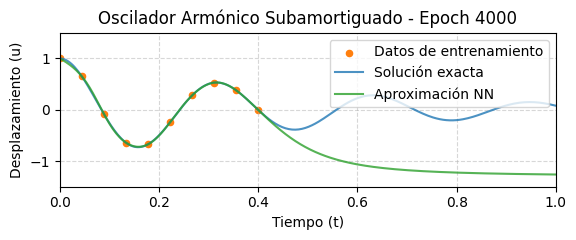

Epoch 5000 - t = 1.000 - Error puntual L2 = 0.849054


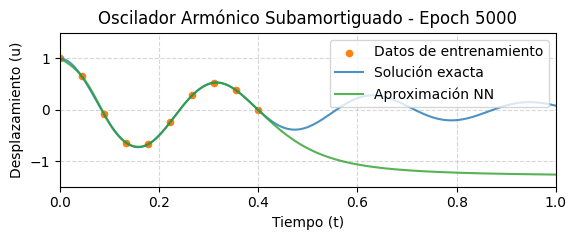

Epoch 6000 - t = 1.000 - Error puntual L2 = 0.848322


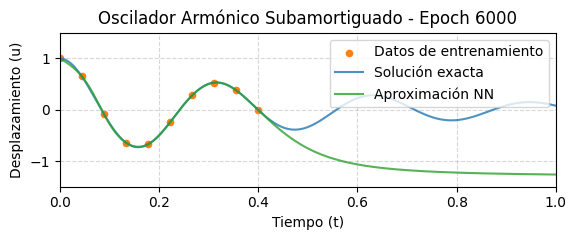

Epoch 7000 - t = 1.000 - Error puntual L2 = 0.846509


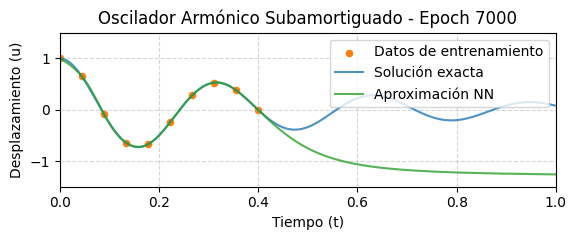

Epoch 8000 - t = 1.000 - Error puntual L2 = 0.845821


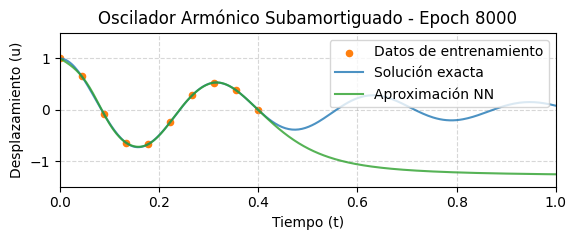

Epoch 9000 - t = 1.000 - Error puntual L2 = 0.843074


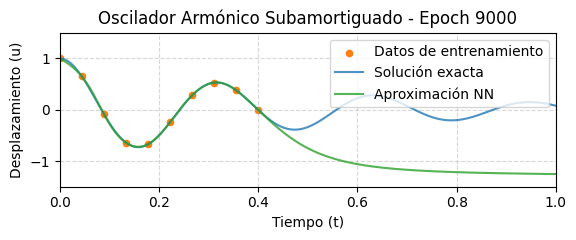

Epoch 10000 - t = 1.000 - Error puntual L2 = 0.840910


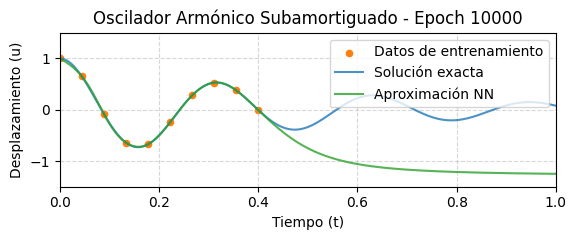

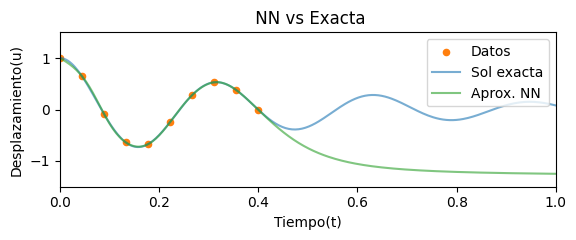

In [18]:
# ---- Evaluación y visualización ----
# Puntos densos para graficar solución completa
t_plot = torch.linspace(0, t_plot_max, 300).reshape(-1,1)
u_exact = exact_solution(d, w0, t_plot)
u_pred = model(t_plot).detach()
# ---- Entrenamiento con visualización periódica ----
loss_history = []

for ep in range(1, epochs + 1):
    pred = model(t_train)
    loss = criterion(pred, u_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    # Gráfica cada 1000 epochs
    if ep % 1000 == 0:
        t_plot = torch.linspace(0, t_plot_max, 300).reshape(-1, 1)
        u_exact = exact_solution(d, w0, t_plot)
        u_pred = model(t_plot).detach()

        # Cálculo del error L2
        # Evaluar modelo y error punto a punto
        for t_val, u_e, u_p in zip(t_plot.view(-1), u_exact.view(-1), u_pred.view(-1)):
          error_L2 = torch.sqrt(torch.mean((u_exact - u_pred)**2))
        print(f"Epoch {ep} - t = {t_val.item():.3f} - Error puntual L2 = {error_L2:.6f}")



        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_train.detach().numpy(), u_train.detach().numpy(),
                    color="tab:orange", s=20, label='Datos de entrenamiento')
        plt.plot(t_plot.detach().numpy(), u_exact.detach().numpy(),
                 color="tab:blue", label='Solución exacta', alpha=0.8)
        plt.plot(t_plot.detach().numpy(), u_pred.detach().numpy(),
                 color="tab:green", label='Aproximación NN', alpha=0.8)

        plt.xlabel('Tiempo (t)')
        plt.ylabel('Desplazamiento (u)')
        plt.title(f'Oscilador Armónico Subamortiguado - Epoch {ep}')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(0, t_plot_max)
        plt.ylim(-1.5, 1.5)
        plt.tight_layout()
        plt.show()



plt.figure(figsize=(6,2.5))
# Datos entrenamiento
plt.scatter(t_train.detach().numpy(), u_train.detach().numpy(), color="tab:orange", s=20, label='Datos')
# Solución exacta
plt.plot(t_plot.detach().numpy(), u_exact.detach().numpy(),color="tab:blue", label='Sol exacta', alpha=0.6)
# Aproximación NN
plt.plot(t_plot.detach().numpy(), u_pred.detach().numpy(), color="tab:green",label='Aprox. NN', alpha=0.6)

plt.xlabel('Tiempo(t)')
plt.ylabel('Desplazamiento(u)')
plt.title(' NN vs Exacta')
plt.legend(loc='upper right')
#plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, t_plot_max)
plt.ylim(-1.5, 1.5)
plt.tight_layout()
# Guardar como PDF
plt.savefig("NNvsExacta.pdf", format="pdf")
plt.show()


##Enforque de redes neuronales informadas por las física
**Enfoque PINNs**

Estamos interesado en mirar el efecto de incoporar la física en el entrenamiento, es decir mirar la eficiencia de las PINNs, en contraste con una NN normal. En particular en este enfoque no necesitamos de  datos etiquetados para que nuestra red neuronal aprenda,  específicamente, nuestras entradas y son  la ecuación diferencial subyacente y las condiciones iniciales del sistema  y las salidas: una estimación de la solución, $u(t)$

#### Enfoque

Como se ha explicado la PINN se entrena para aproximar directamente la solución de la ecuación diferencial, es decir,

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ representa los parámetros libres de la PINN.

#### Función de pérdida

Para simular el sistema, la PINN se entrena con la siguiente función de pérdida:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

Para esta tarea, usamos  los mismos parametros $\delta$, $\omega_0=$  del enfoque anterior y tratamos de aprender la solución en el dominio $t \in [0,10]$.

#### Notas

Los dos primeros términos en la función de pérdida representan la **pérdida de frontera**, y buscan asegurar que la solución aprendida por la PINN respete las condiciones iniciales del sistema, a saber: $u(t=0)=1$ y $u'(t=0)=0$.

El segundo término en la función de pérdida se denomina **pérdida física**, y busca asegurar que la solución de la PINN cumpla la ecuación diferencial en un conjunto de puntos de entrenamiento $\{t_i\}$ muestreados en todo el dominio.

Los hiperparámetros $\lambda_1$ y $\lambda_2$ se utilizan para balancear los términos en la función de pérdida y asegurar la estabilidad durante el entrenamiento.

Se utiliza autodiferenciación (`torch.autograd`) para calcular los gradientes de la PINN respecto a su entrada, lo cual es necesario para evaluar la función de pérdida. ¡Esto es muy potente!

Para más detalles sobre `torch.autograd`, consultar [este tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd).

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.363773


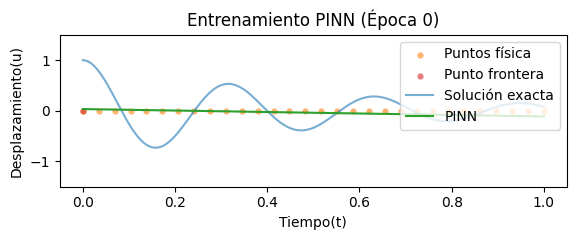

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.196624


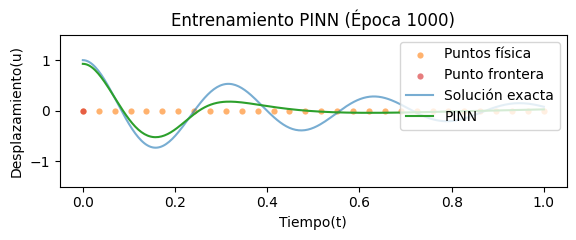

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.128075


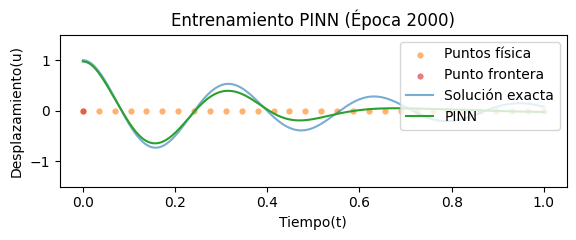

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.100728


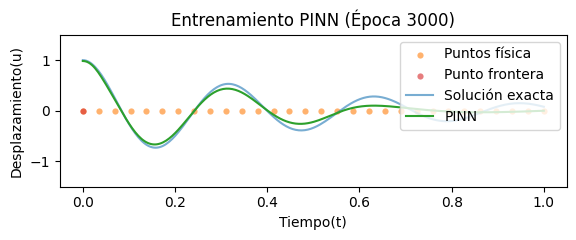

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.087577


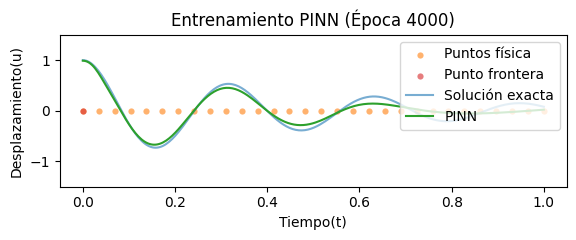

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.089072


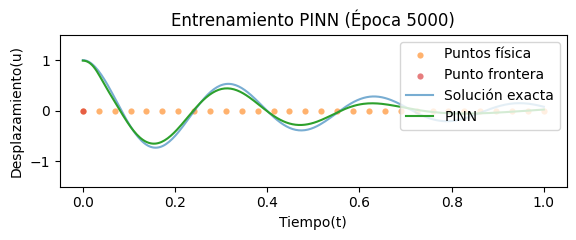

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.094435


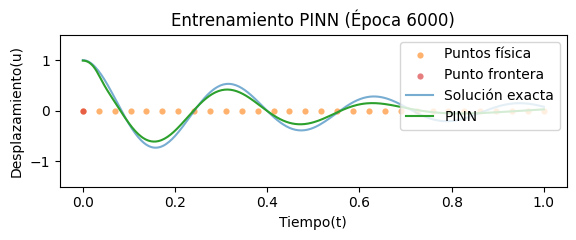

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.101779


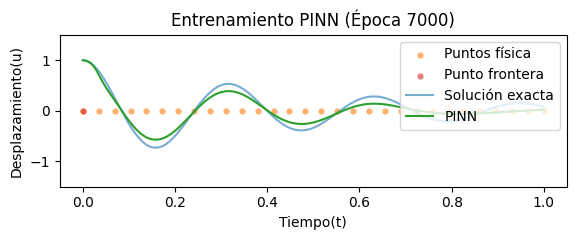

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.106775


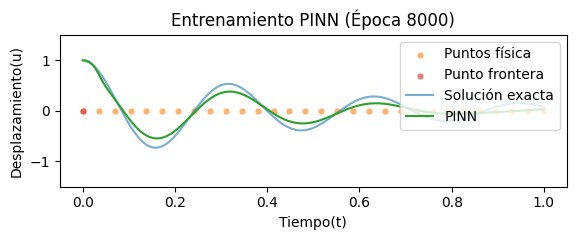

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.110728


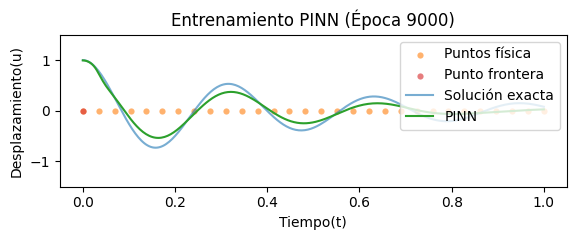

Epoch 10001 - t = 1.000 - Error puntual L2 = 0.110932


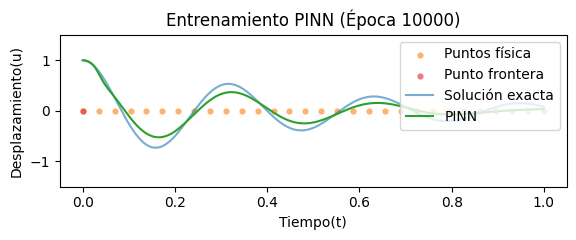

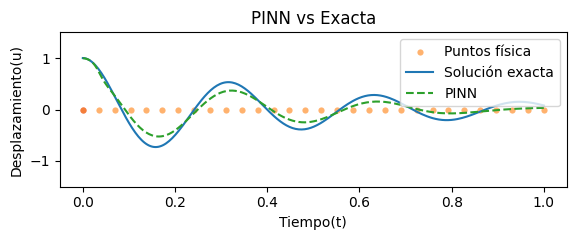

In [19]:

# Definición de la red neuronal igual que en el primer enfoque
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,50), nn.Tanh(),
            nn.Linear(50,1)
        )
    def forward(self, x):
        return self.net(x)

torch.manual_seed(123)

# Usamos la misma arquitectura que en el primer código
pinn = SimpleNN()

# Definición de puntos de frontera y física
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)

# Parámetros físicos (iguales al primer código)
d = 2.0
w0 = 20.0
mu, k = 2*d, w0**2  # Coeficientes de la ecuación diferencial
lambda1, lambda2 = 1e-1, 1e-4
# Puntos para evaluación
t_test = torch.linspace(0, 1, 300).reshape(-1,1)
u_exact = exact_solution(d, w0, t_test)

# Optimizador
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)


# Inicializar lista para almacenar el historial de pérdida
loss_history = []

# Entrenamiento
for i in range(10001):
    optimiser.zero_grad()

    # Pérdida en la frontera (condiciones iniciales)
    u_boundary = pinn(t_boundary)
    loss1 = (torch.squeeze(u_boundary) - 1)**2  # Condición inicial: u(0) = 1
    dudt = torch.autograd.grad(u_boundary, t_boundary,
                               torch.ones_like(u_boundary),
                               create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2  # Condición inicial: du/dt(0) = 0

    # Pérdida física (ecuación diferencial)
    u_physics = pinn(t_physics)
    dudt_physics = torch.autograd.grad(u_physics, t_physics,
                                       torch.ones_like(u_physics),
                                       create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt_physics, t_physics,
                                 torch.ones_like(dudt_physics),
                                 create_graph=True)[0]

    # Ecuación: u'' + μu' + ku = 0
    physics_loss = d2udt2 + mu*dudt_physics + k*u_physics
    loss3 = torch.mean(physics_loss**2)

    # Pérdida total
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # Guardar valor de la pérdida para graficar
    loss_history.append(loss.item())

    # Visualización durante el entrenamiento
    if i % 1000 == 0:
        u_pred = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))

        # Cálculo del error L2
        # Evaluar modelo y error punto a punto
        for t_val, u_e, u_p in zip(t_plot.view(-1), u_exact.view(-1), u_pred.view(-1)):
          error_L2 = torch.sqrt(torch.mean((u_exact - u_pred)**2))
        print(f"Epoch {ep} - t = {t_val.item():.3f} - Error puntual L2 = {error_L2:.6f}")


        # Puntos de entrenamiento
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0],
                    s=20, lw=0, color="tab:orange", alpha=0.6,
                    label='Puntos física')

        # Punto frontera
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0],
                    s=20, lw=0, color="tab:red", alpha=0.6,
                    label='Punto frontera')

        # Soluciones
        plt.plot(t_test[:,0], u_exact[:,0],
                 label="Solución exacta", color="tab:blue", alpha=0.6)
        plt.plot(t_test[:,0], u_pred[:,0],
                 label="PINN", color="tab:green")

        plt.xlabel('Tiempo(t)')
        plt.ylabel('Desplazamiento(u)')
        plt.title(f'Entrenamiento PINN (Época {i})')
        plt.legend(loc='upper right')
        plt.ylim(-1.5, 1.5)
        plt.tight_layout()
        plt.show()

# Gráfico final comparativo
u_pred_final = pinn(t_test).detach()
plt.figure(figsize=(6,2.5))
plt.scatter(t_boundary.detach()[:,0],
            torch.zeros_like(t_boundary)[:,0],
            s=20, lw=0, color="tab:red", alpha=0.6)
plt.scatter(t_physics.detach()[:,0],
            torch.zeros_like(t_physics)[:,0],
            s=20, lw=0, color="tab:orange", alpha=0.6,
            label='Puntos física')
plt.plot(t_test[:,0], u_exact[:,0], label="Solución exacta", color="tab:blue")
plt.plot(t_test[:,0], u_pred_final[:,0], label="PINN", color="tab:green", linestyle='--')
plt.xlabel('Tiempo(t)')
plt.ylabel('Desplazamiento(u)')
plt.title('PINN vs Exacta')
plt.legend(loc='upper right')
plt.ylim(-1.5, 1.5)
plt.tight_layout()
plt.savefig("PINN_vs_Exacta.pdf", format="pdf")
plt.show()



>Graficar el funcional de perdida


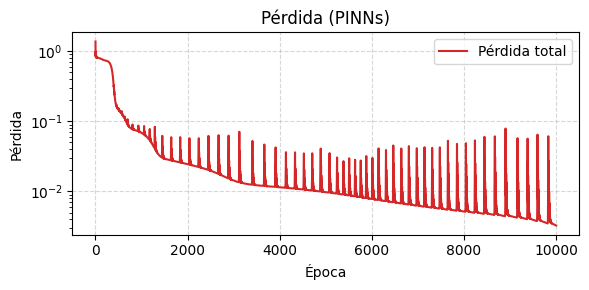

In [20]:

# ---- Curva de pérdida ----
plt.figure(figsize=(6, 3))
plt.semilogy(loss_history, color="tab:red", label='Pérdida total')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida (PINNs)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Curva_Perdida_PINN.pdf", format="pdf")
plt.show()
